# Homework 2 Exercise 2 - Hierarchical Probabilistic Model

Brennan McFarland  
bfm21

Suppose we are building a population model as part of a scientific study for determining the survival rate of different species on an island.  Let us suppose the island contains foxes, rabbits, birds, carrots and seeds, and we want to model the proportion of any such species surviving to reproduction.  Since foxes eat rabbits and birds, rabbits eat carrots and birds eat seeds, let's suppose the survival rate of each species is dependent on the survival rate of its respective predator, forming a cause-and-effect relationship from predator to prey.

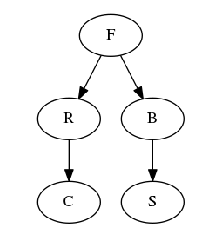

In [98]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as imtool

image_format = 'png'
dot = Digraph(format=image_format)
dot.node('F', 'F')
dot.node('R', 'R')
dot.node('B', 'B')
dot.node('C', 'C')
dot.node('S', 'S')
dot.edges(['FR', 'FB', 'RC', 'BS'])
path = 'exercise2-graph'
dot.render(path)
imorg = imtool.imread(path + '.' + image_format)
plt.axis('off')
plt.imshow(imorg)

## Probabilities

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import math

max_pop = 10000

Let us define the a probabilistic model in PyMC3 with the survival rate of each species modeled as a Beta distribution.  The alpha and/or beta parameters of each prey's distribution are dependent on the distribution of its respective predator.

In [100]:
import pymc3
from pymc3 import Bernoulli
from pymc3 import Beta
from pymc3.math import switch

model = pymc3.Model()

with model:
    Foxes = Beta('Foxes', alpha=2, beta=5)
    Rabbits = Beta('Rabbits', alpha=Foxes, beta=Foxes*5)
    Birds = Beta('Birds', alpha=Foxes*2, beta=Foxes*6)
    Carrots = Beta('Carrots', alpha=Rabbits*.7, beta=2)
    Seeds = Beta('Seeds', alpha=Birds*.3, beta=4)

## Sample Generation

We can sample our model to generate a trace.  Note that the distributions were selected to represent a plausible real-world situation, where predators tend to have a much higher survival rate than prey farther down the food chain since more of them are eaten and have to reproduce to compensate.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/user/.local/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Seeds_logodds__, Carrots_logodds__, Birds_logodds__, Rabbits_logodds__, Foxes_logodds__]
100%|██████████| 10500/10500 [02:46<00:00, 63.21it/s]
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


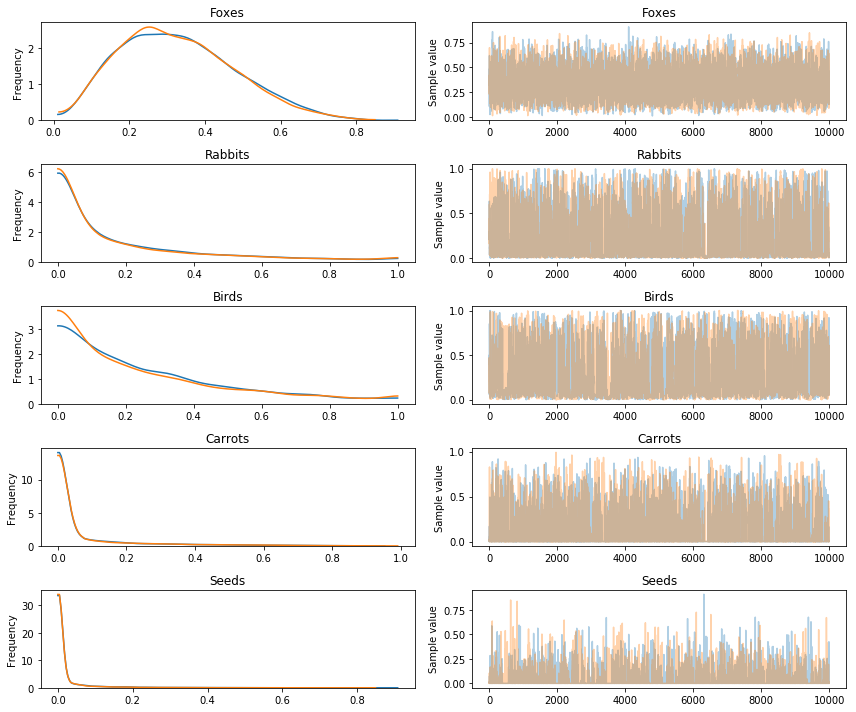

In [101]:
%matplotlib inline
samples = 10000
with model:
    trace = pymc3.sample(samples, chains=2)
    pymc3.traceplot(trace)

## Posterior Inference

In [105]:
# returns the cdf, integral of the distribution up to a point
def conditional_probability(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] < v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] < v]
    # calculate conditional probability
    return len(trace) / nCondSample

Now say for example we can more easily directly observe static plant life than wandering predators, and thus want to calculate the survival rate of foxes based on the survival rate of carrots and seeds, $P(F|C,S)$:

The integral version of straight summation gives us  
$P(F|C,S) = \alpha P(F,C,S) = \alpha \int_{B,R}P(C|R)P(S|B)P(R|F)P(B|F)P(F)$  
We can pull variables out of the integrals to get  
$P(F|C,S) = \alpha P(F)\int_{B}P(S|B)P(B|F)\int_{R}P(C|R)P(R|F)$  
Our normalizing constant $\alpha$ is $\frac{1}{P(C,S)}$ and $P(C,S)=\int_{B,R}P(C,S|B,R)P(B|F)P(R|F)P(F)$  
So our final expression is
$P(F|C,S) = \frac{1}{\int_{B,R}P(C,S|B,R)P(B|F)P(R|F)P(F)} P(F)\int_{B}P(S|B)P(B|F)\int_{R}P(C|R)P(R|F)$

Let us use the following variables for our rates of survival:

In [111]:
test_rate_foxes = .4
test_rate_carrots = .2
test_rate_seeds = .7

We can calculate the corresponding cdfs from our model to determine our value of P(F|C,S):

In [112]:
print('P(F|C,S) = ',
     conditional_probability(trace,
                            {'Foxes' : test_rate_foxes},
                            {'Carrots' : test_rate_carrots, 'Seeds' : test_rate_seeds}))

P(F|C,S) =  0.6930861951330453
